In [125]:
import numpy as np
import os
import pandas as pd
import itertools
from PIL import Image
import seaborn as sns
import fitsio
import skimage.io
import galsim

from astrometry.util.fits import fits_table, merge_tables


# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
REPO_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan')
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata')

# Galsim: demo[0-9].py

In [126]:
gal_flux = 1.e5    # total counts on the image
rhalf = 2.     # arcsec
psf_sigma = 1.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30. # standard 

gal = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal = gal.shear(e1=0.3, e2=-0.8)
rot_gal= gal.rotate(np.pi/2.* galsim.radians)
psf = galsim.Gaussian(flux=1., sigma=psf_sigma) # PSF flux should always = 1
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

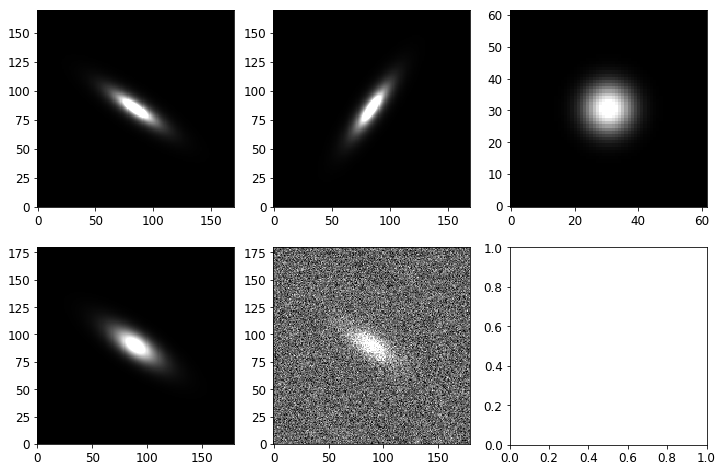

In [127]:
def readImage(fn,jpeg=False,ext=1):
    """Reads FITS and jpeg images so that x,y indices refer to the same pixels
    regardless of image format. x,y and fits correspond so the jpeg is rotated and flipped 
    to align with fits
    
    Args:
        fn: image filename
        jpeg: bool, is is a jpeg?
    """
    if jpeg:
        img= skimage.io.imread(fn)
        for i in range(3):
            img[:,:,i]= np.rot90(img[:,:,i].T,1)
    else:
        img= fitsio.FITS(fn)[ext].read()
    return img

def sliceImage(img,
               xslice=slice(None,None),yslice=slice(None,None)):
    """Not sure why, but simcat.x[xslice],simcat.y[yslice]
    corresponds to img[yslice,xslice], eg inverted for the image"""
    return img[yslice,xslice,...]

class plotImage(object):
    """Helper functions for displaying image and overlaying circles around sources
    
    Args:
        img: need to give as initial input b/c some helper funcs that dont directly
            use img, need its shape at least, see circles()
    """
    def imshow(self,img,ax,qs=[0.5,99.5]):
        if img.shape[-1] == 3:
            #minmax=np.percentile(np.sum(img,axis=2),q=qs)
            minmax=[None,None]
            cmap=None
        else:
            minmax=np.percentile(img,q=qs)
            cmap='gray'
        ax.imshow(img, interpolation='none', origin='lower',
                  cmap=cmap,vmin=minmax[0],vmax=minmax[1])
        ax.tick_params(direction='out')

fig,ax= plt.subplots(2,3,figsize=(12,8))
kw={'scale':pixel_scale}
plotImage().imshow(gal.drawImage(**kw).array,ax[0,0])
plotImage().imshow(rot_gal.drawImage(**kw).array,ax[0,1])
plotImage().imshow(psf.drawImage(**kw).array,ax[0,2])
plotImage().imshow(final.drawImage(**kw).array,ax[1,0])
plotImage().imshow(image.array,ax[1,1])

In [128]:
ba= np.random.rand(1000)
ba= ba[ba > 0.1]
beta= np.random.rand(len(ba))*180


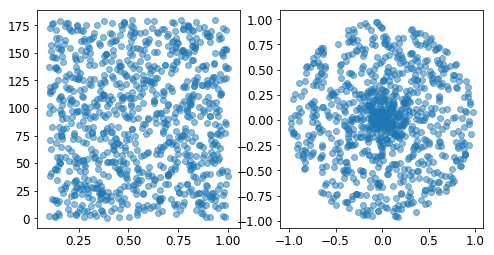

In [129]:
def ellip(q):
    """q: b/a ratio"""
    return (1-q**2)/(1+q**2)

def e1_e2(q,beta):
    """
    q: b/a ratio
    beta: rotation
    """
    e= ellip(q)
    return e*np.cos(2*beta), e*np.sin(2*beta)

fig,ax= plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(ba,beta,alpha=0.5)
e1,e2= e1_e2(ba,beta)
ax[1].scatter(e1,e2,alpha=0.5)

### Can galsim draw all these orientations?

In [19]:
for one,two in zip(e1,e2):
    gal.shear(e1=one, e2=two)

# DECam CCD + PSFex psf

In [104]:
from legacypipe.decam import DecamImage
from legacypipe.survey import LegacySurveyData

In [21]:
ccds= fits_table(os.path.join(DATA_DIR,
                             '1741p242/dr5/legacysurvey-1741p242-ccds.fits'))
t= ccds[((pd.Series(ccds.image_filename).str.contains('c4d_160116_084245_oki_z_v1.fits')) &
         (ccds.ccdname == 'S17'))]
#for col in ['image_filename','ccdname','filter','camera']:
#    t.set(col,t.get(col)[0])
#t

In [47]:
im.get_tractor_image?

In [106]:
# Generator class for LegacySurveyImage() objects
survey = LegacySurveyData(ccds=ccds)
#survey= DecamImage(ccds=)
for ccd in t:
    # a LegacySurveyImage
    im = survey.get_image_object(ccd)
#X = im.get_good_image_subregion()
kwargs = dict(pixPsf=True, splinesky=True, subsky=False, hybridPsf=True,
              pixels=True, dq=True, invvar=True)
tim = im.get_tractor_image(**kwargs)



On NERSC, you can do:
  module use /project/projectdirs/cosmo/work/decam/versions/modules
  module load legacysurvey

Now using the current directory as LEGACY_SURVEY_DIR, but this is likely to fail.

Reading image slice: None
Reading image from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz hdu 15
Reading inverse-variance from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_oow_z_v1.fits.fz hdu 15
Reading data quality from /home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_ood_z_v1.fits.fz hdu 15
Reading merged spline sky models from /home/kaylan/myrepo/obiwan/doc/nb/calib/decam/splinesky-merged/00511/decam-00511967.fits
Found 1 matching CCD
Reading merged PsfEx models from /home/kaylan/myrepo/obiwan/doc/nb/calib/decam/psfex-merged/00511/decam-00511967.fits
Found 1 matching CCD
Using PSF model HybridPixelizedPSF: Gaussian sigma 1.73, Pix PixelizedPsfEx
-- creat

In [197]:
tim.getImage().max(),tim.invvar.shape,tim.data.shape,tim.dq.shape

(77.765678, (4094, 2046), (4094, 2046), (4094, 2046))

In [133]:
psf = tim.psf
wcs = tim.wcs.wcs
sky = tim.sky

## How draw a 22 mag galaxy in a tim image which has NanoMaggie units?

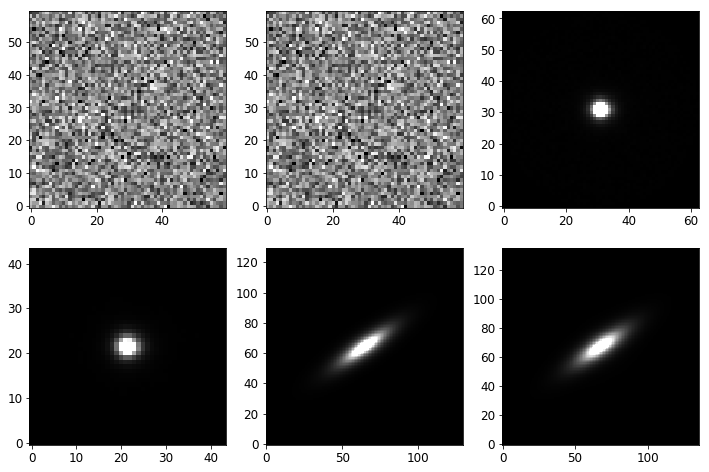

In [205]:
def magToNanomaggies(mag):
    nmgy = 10. ** ((mag - 22.5) / -2.5)                                        
    return nmgy

def galsimWcs(tim):
    from astropy.io import fits
    #self.wcs = tim.getWcs()
    #self.psf = tim.getPsf()
    # Tractor wcs object -> galsim wcs object
    temp_hdr = fitsio.FITSHDR()
    subwcs = tim.wcs.wcs.get_subimage(tim.wcs.x0, tim.wcs.y0,
                              int(tim.wcs.wcs.get_width())-tim.wcs.x0,
                              int(tim.wcs.wcs.get_height())-tim.wcs.y0)
    subwcs.add_to_header(temp_hdr)
    # Galsim uses astropy header, not fitsio
    hdr = fits.Header()
    for key in temp_hdr.keys(): 
        hdr[key]=temp_hdr[key]
    return galsim.GSFitsWCS(header=hdr)
    
xpos,ypos,hw= 1000,1000,30
wcs_galsim= galsimWcs(tim)
local_wcs_galsim= wcs_galsim.local(image_pos= galsim.PositionD(xpos, ypos)) 

xslc=slice(xpos-hw,xpos+hw)
yslc=slice(ypos-hw,ypos+hw)
psf_tim= tim.psf.getPointSourcePatch(xpos, ypos)
psf_galsim = galsim.InterpolatedImage(galsim.Image(psf_image), 
                                      wcs= local_wcs_galsim)

gal = galsim.Sersic(1,flux=magToNanomaggies(22.), half_light_radius=2.)
gal= gal.shear(e1=0.3, e2=-0.8)
gal= gal.rotate(np.pi/2.* galsim.radians)

conv_gal= galsim.Convolve([gal, psf_galsim])

fig,ax= plt.subplots(2,3,figsize=(12,8))
kw={'scale':pixel_scale}
plotImage().imshow(sliceImage(cp,xslice=xslc,yslice=yslc),ax[0,0])
plotImage().imshow(sliceImage(tim.getImage(),xslice=xslc,yslice=yslc),ax[0,1])
plotImage().imshow(psf_tim.getImage(),ax[0,2])
##
plotImage().imshow(psf_galsim.drawImage(wcs=local_wcs_galsim).array,ax[1,0])
plotImage().imshow(gal.drawImage(wcs=local_wcs_galsim).array,ax[1,1])
plotImage().imshow(conv_gal.drawImage(wcs=local_wcs_galsim).array,ax[1,2])

## Add poisson noise from simulated source

In [206]:
gain= 4.
nano2e= tim.zpscale*gain 
src_e= conv_gal.drawImage(wcs=local_wcs_galsim).copy() * nano2e 
src_var_e= src_e.copy()**2
rng = galsim.BaseDeviate(7)
src_e.addNoise(galsim.VariableGaussianNoise(rng,src_var_e))
src_cnts= src_e / nano2e

(-4.2128099e-06, -1.1980349e-10, 0.00044387573)

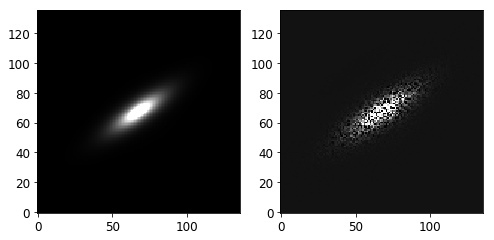

In [208]:
fig,ax= plt.subplots(1,2,figsize=(8,4))
plotImage().imshow(conv_gal.drawImage(wcs=local_wcs_galsim).array,ax[0])
plotImage().imshow(src_cnts.array,ax[1])
diff= src_cnts.array - conv_gal.drawImage(wcs=local_wcs_galsim).array
diff.mean(), np.median(diff), np.std(diff)

## Add it to the tim image

In [212]:
# Test that overlapping region of stamp is same tim image slice as above
tim_image= galsim.Image(tim.getImage(),wcs=local_wcs_galsim)

In [213]:
overlap = src_cnts.bounds & tim_image.bounds
print(tim_image.bounds,src_cnts.bounds,overlap)

(galsim.BoundsI(xmin=1, xmax=2046, ymin=1, ymax=4094), galsim.BoundsI(xmin=1, xmax=136, ymin=1, ymax=136), galsim.BoundsI(xmin=1, xmax=136, ymin=1, ymax=136))


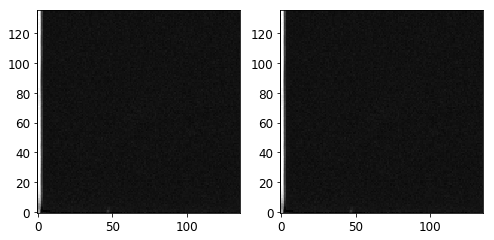

In [211]:

assert(overlap.area() > 0)
tim_image[overlap]= tim_image[overlap] + src_cnts[overlap]
   
fig,ax= plt.subplots(1,2,figsize=(8,4))
plotImage().imshow(galsim.Image(tim.getImage())[overlap].array,ax[0])
plotImage().imshow(tim_image[overlap].array,ax[1])

## tim.getImage() is in units of "NanoMaggies", while CP CCD is units of CP. Can I predict what these should be?

In [135]:
hdu=fitsio.FITS('images/decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz')
cp=hdu['S17'].read()
cp.max(), tim.getImage().max()

(51861.047, 77.765678)

In [108]:
hdu=fitsio.FITS('images/decam/DECam_CP/CP20160107/c4d_160116_084245_oow_z_v1.fits.fz')
cp_ivar=hdu['S17'].read()

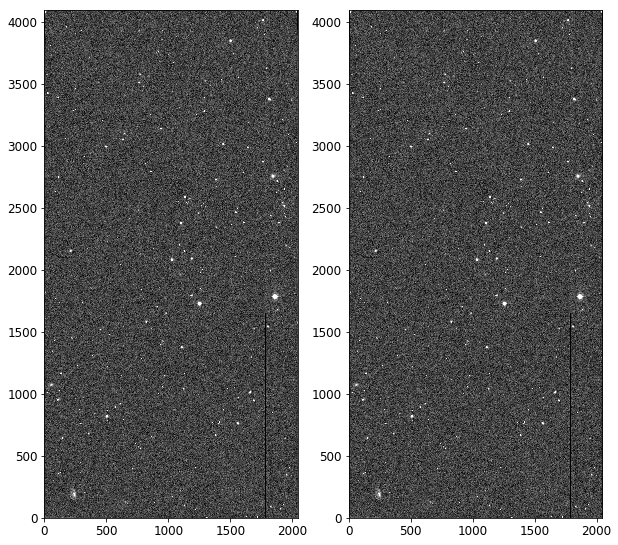

In [109]:
fig,ax= plt.subplots(1,2,figsize=(10,10))
plotImage().imshow(tim.getImage(),ax[0])
plotImage().imshow(cp,ax[1])
#psfim = self.psf.getPointSourcePatch(self.xpos, self.ypos).getImage()

## ratio of CP image to tim Image should be zpscale

In [110]:
slc= slice(1000,1500)
img_ratio= (cp/tim.getImage())[slc,slc].flatten()
ivar_ratio= (tim.getInvvar()/cp_ivar)[slc,slc].flatten()
set(img_ratio),set(ivar_ratio)

/home/kaylan/env_galsim/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


({666.88855, 666.88861, 666.88867},
 {-0.0,
  444740.31,
  444740.34,
  444740.38,
  444740.41,
  444740.44,
  444740.47,
  444740.5})

In [111]:
tim.zpscale

666.88859076847427

In [118]:
zp= t.ccdzpt + 2.5 * np.log10(t.exptime)
zpscale= 10**(zp - 22.5)/2.5
zpscale

array([ 4594021.], dtype=float32)

In [115]:
t.zpt

array([ 24.81708145], dtype=float32)

In [88]:

img_ratio= f
ivar_ratio= f**2
print(img_ratio,ivar_ratio)

(array([ 4594021.], dtype=float32), array([  2.11050289e+13], dtype=float32))


## How does the PSF vary across the CCD image?

In [78]:
t.ccdzpt, t.ccdzpt + 2.5 * np.log10(t.exptime)

(array([ 24.80240822], dtype=float32), array([ 29.56013298], dtype=float32))

In [79]:
im.ccdzpt

29.560133218765259